# Load packages

In [1]:
import os
from matplotlib import pyplot as plt
import matplotlib.path as mpath
import numpy as np
import pandas as pd
import xarray as xr
import cartopy
%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 6
%config InlineBackend.figure_format = 'retina' 

In [3]:
"""
from dask.distributed import Client
from dask_kubernetes import KubeCluster
cluster = KubeCluster()
cluster.adapt(minimum=1, maximum=10, interval='2s')
client = Client(cluster)
client"""

"\nfrom dask.distributed import Client\nfrom dask_kubernetes import KubeCluster\ncluster = KubeCluster()\ncluster.adapt(minimum=1, maximum=10, interval='2s')\nclient = Client(cluster)\nclient"

# Load RACMO data

In [4]:
dsr = xr.open_dataset('../data/RACMO_ANT27_t2m_season.nc')
dl = dsr.load()
dl

<xarray.Dataset>
Dimensions:     (ncl0: 40, ncl1: 240, ncl2: 262, ncl3: 40, ncl4: 240, ncl5: 262, ncl6: 240, ncl7: 262, ncl8: 240, ncl9: 262)
Dimensions without coordinates: ncl0, ncl1, ncl2, ncl3, ncl4, ncl5, ncl6, ncl7, ncl8, ncl9
Data variables:
    t2m_summer  (ncl0, ncl1, ncl2) float32 284.5 284.4 284.3 ... 279.5 279.5
    t2m_winter  (ncl3, ncl4, ncl5) float32 280.4 280.3 280.3 ... 276.8 276.9
    masker      (ncl6, ncl7) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    height      (ncl8, ncl9) float64 -0.004977 -0.004977 ... -0.004977 -0.004977

### Get mask and Lat/Lon information

In [17]:
mask2d= dl.masker.values
lon2d = dl.masker.lon2d.reshape(dl.masker.shape)
lat2d = dl.masker.lat2d.reshape(dl.masker.shape)

lon2d.shape, lat2d.shape, mask2d.shape, dl.masker.shape, dl.masker.lon2d.shape, dl.masker.lat2d.shape

((240, 262), (240, 262), (240, 262), (240, 262), (62880,), (62880,))

In [16]:
240*262

62880

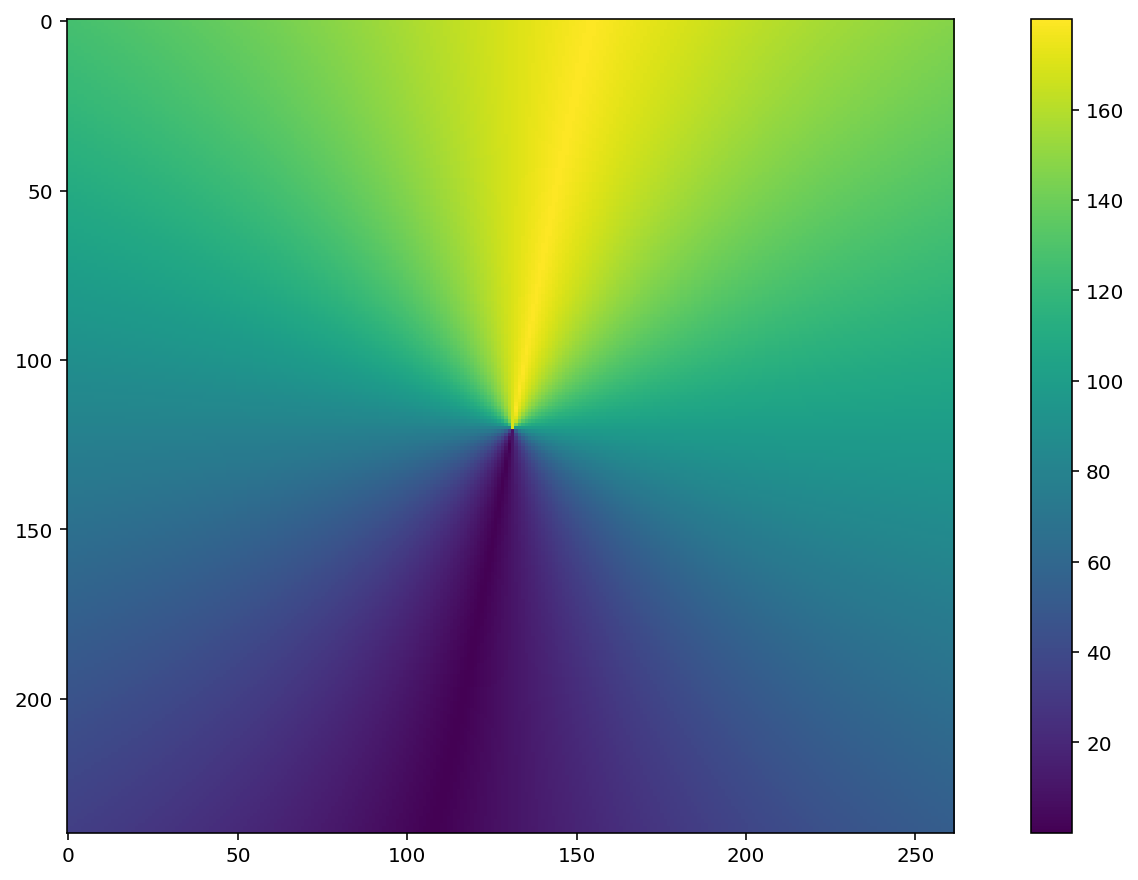

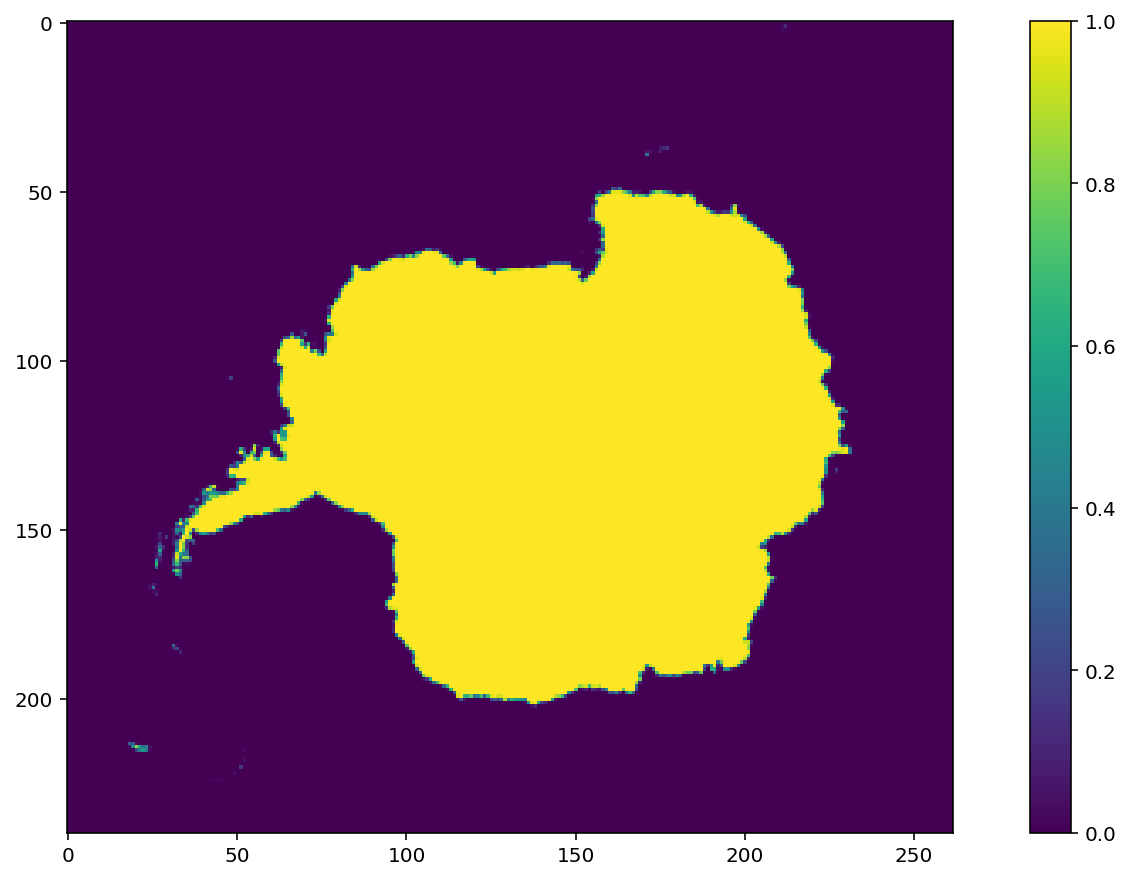

In [6]:
fig1, ax1 = plt.subplots(constrained_layout=True)
i1=ax1.imshow(np.abs(lon2d))
fig1.colorbar(i1)

fig2, ax2 = plt.subplots(constrained_layout=True)
i2=ax2.imshow(mask2d)
fig2.colorbar(i2)

### Define resampling grid

In [17]:
res = 0.25
lat = np.arange(-90, -45, res)
lon = np.arange(-180,180, res)
grid_x, grid_y = np.meshgrid(lon,lat)
points=list(zip(lon2d.flatten(),lat2d.flatten()))

In [18]:
from scipy.interpolate import griddata
grid_z0 = griddata(points, mask2d.flatten(), (grid_x, grid_y), method='nearest')
grid_z1 = griddata(points, mask2d.flatten(), (grid_x, grid_y), method='linear')
grid_z2 = griddata(points, mask2d.flatten(), (grid_x, grid_y), method='cubic')

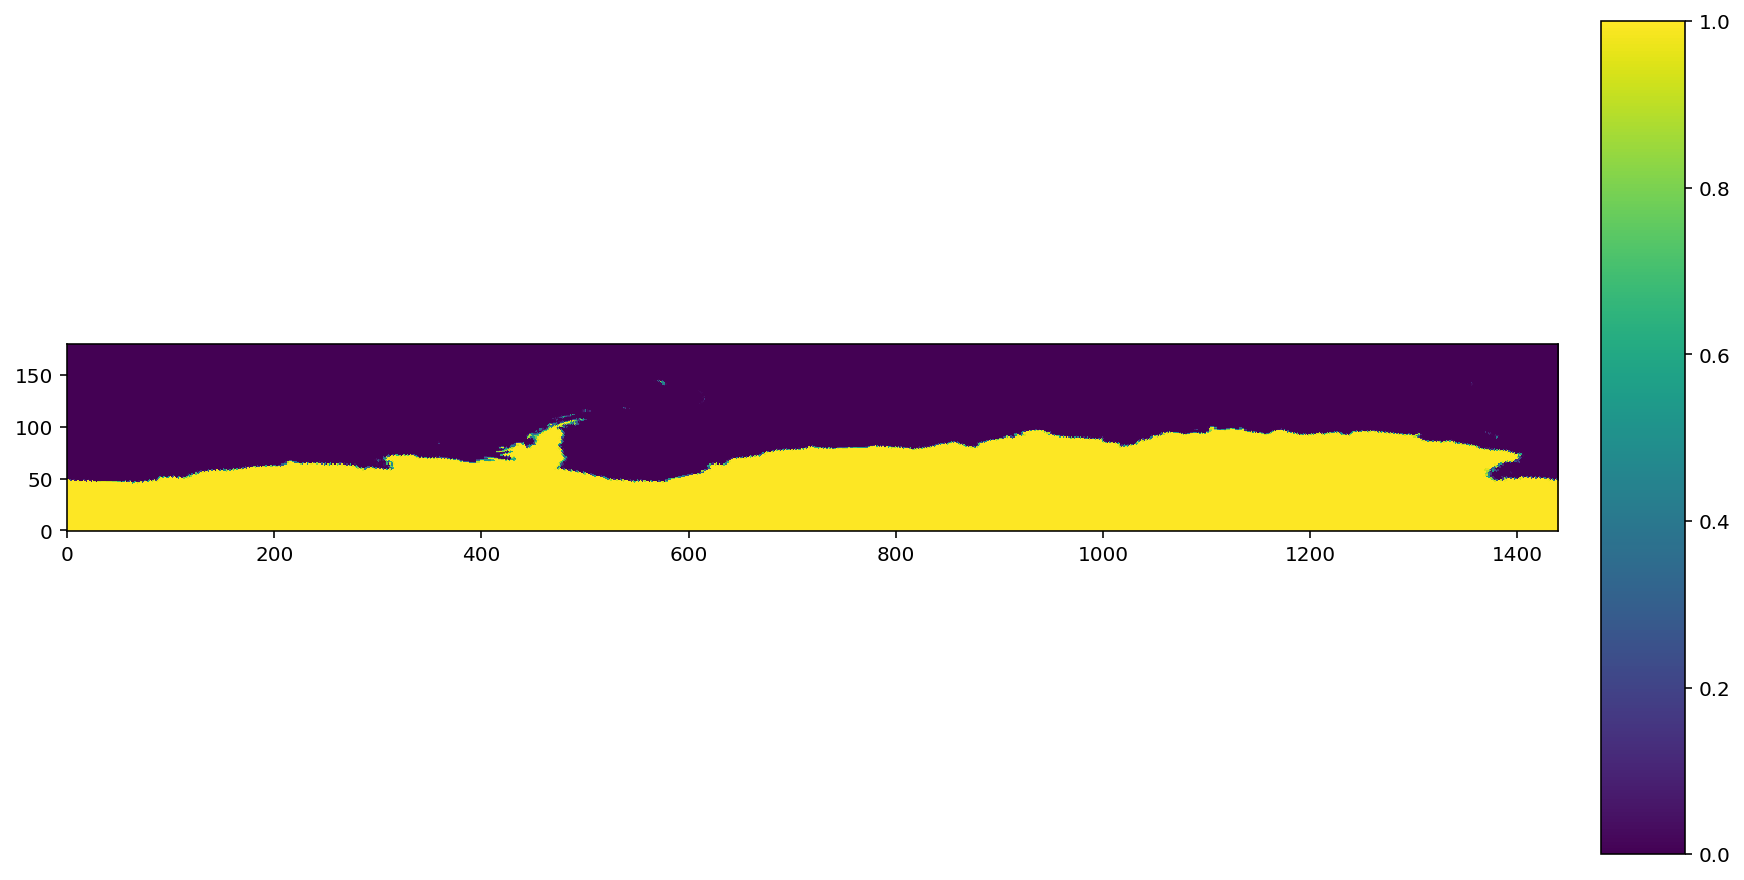

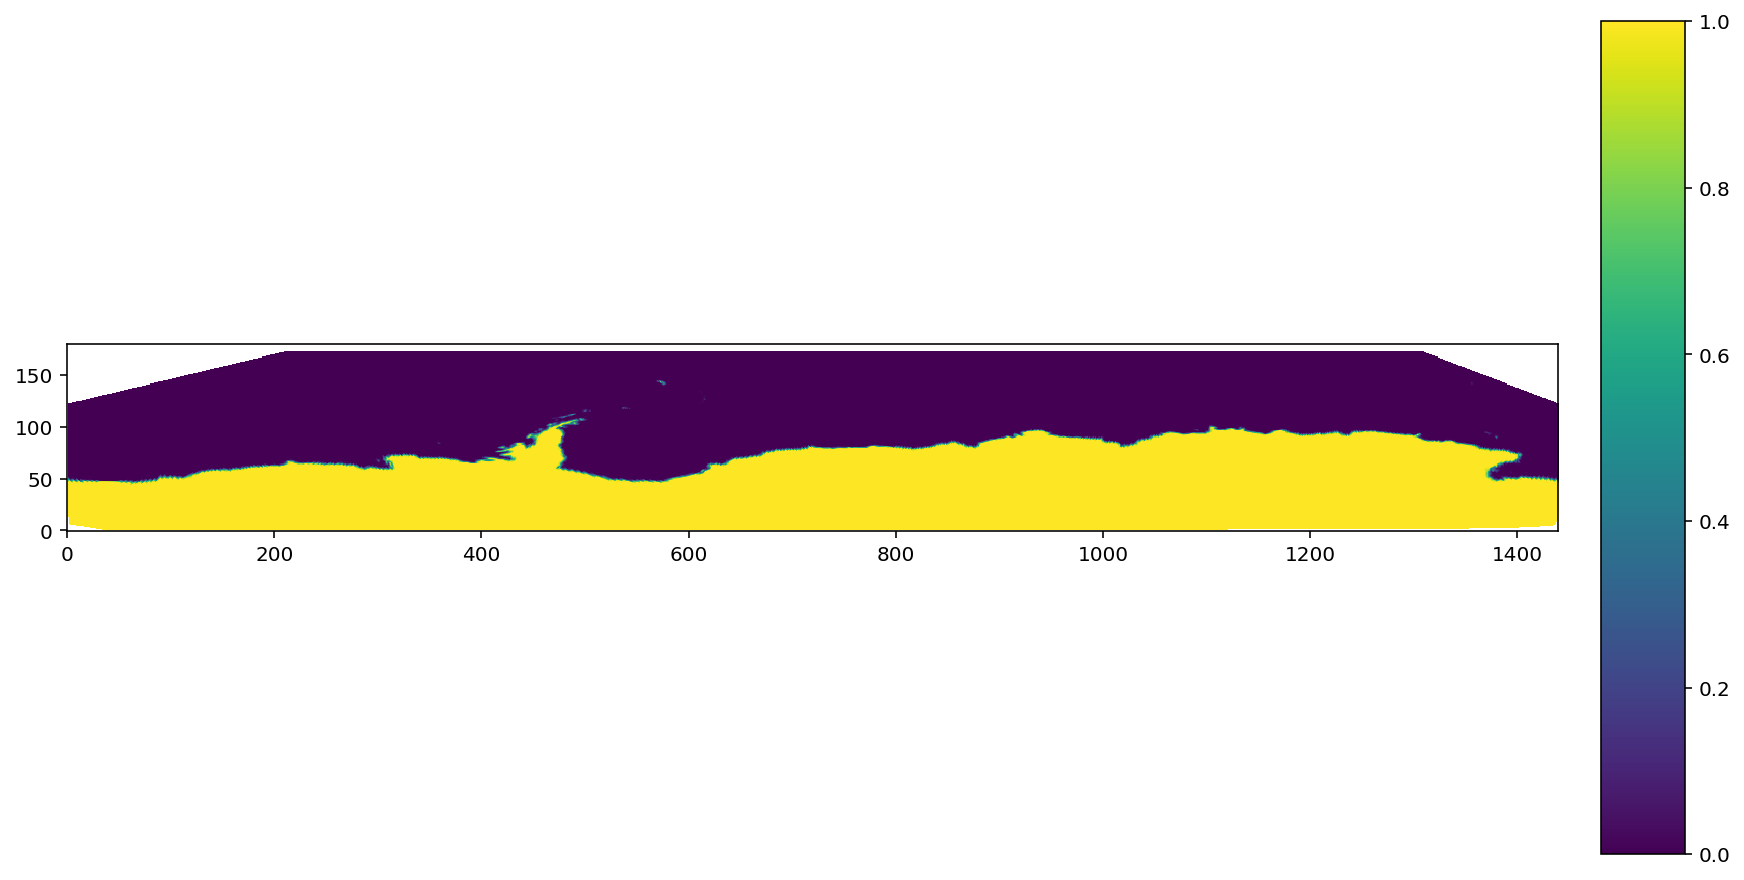

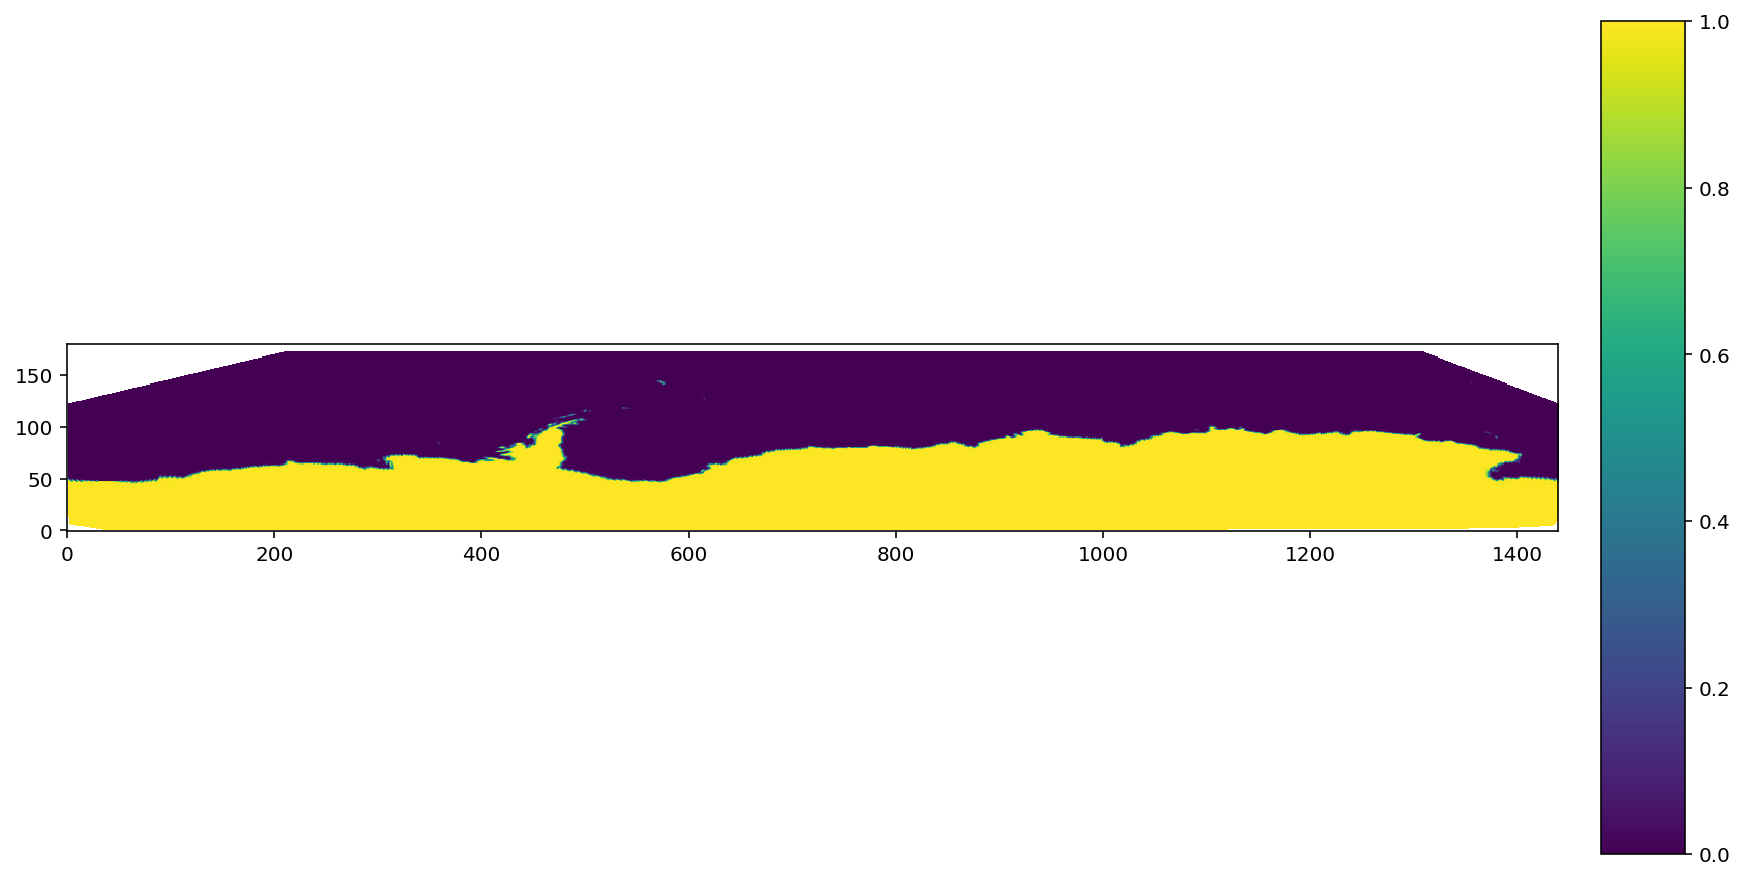

In [19]:
for i in [grid_z0,grid_z1,grid_z2]:
    fig, ax = plt.subplots(constrained_layout=True)
    im=ax.imshow(i,origin='lower',vmax=1,vmin=0)
    fig.colorbar(im)

In [20]:
grid_z1[np.isnan(grid_z1)]=grid_z0[np.isnan(grid_z1)]

In [21]:
da = xr.DataArray(data=grid_z1, dims=["lat", "lon"], coords=[lat,lon])
da

<xarray.DataArray (lat: 180, lon: 1440)>
array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * lat      (lat) float64 -90.0 -89.75 -89.5 -89.25 ... -45.75 -45.5 -45.25
  * lon      (lon) float64 -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8

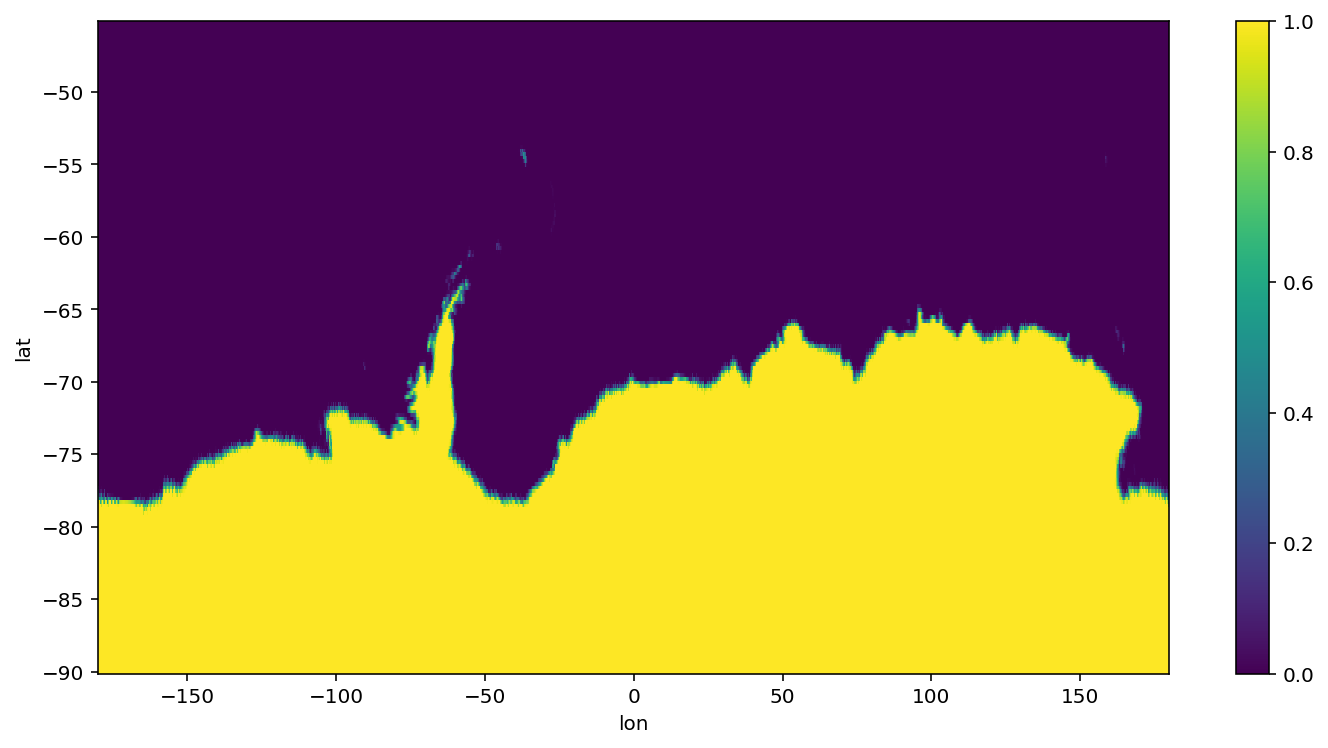

In [22]:
da.plot()

In [24]:
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

In [30]:
crsx = cartopy.crs.Stereographic(central_latitude=-90,true_scale_latitude=-71)
ext=[-180,180,-55,-90]

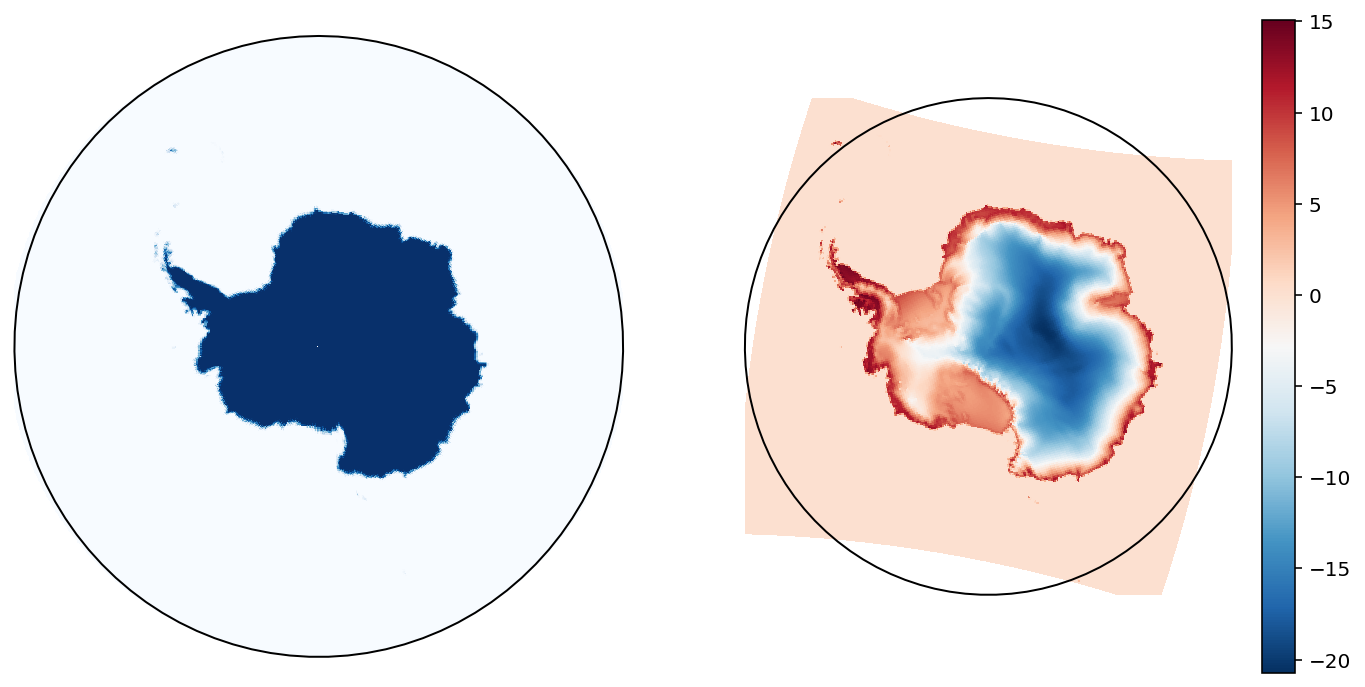

In [31]:
# Fig 1
ax = plt.subplot(121,projection=crsx)
ax.set_extent(ext,crs=cartopy.crs.PlateCarree())
ax.imshow(da.values,extent=ext,vmax=1,cmap='Blues',transform=cartopy.crs.PlateCarree(),origin='upper')
ax.set_boundary(circle, transform=ax.transAxes)
# Fig 2
ax = plt.subplot(122,projection=crsx)
ax.set_extent(ext,crs=cartopy.crs.PlateCarree())
a = ax.pcolormesh(lon2d, lat2d, dl.t2m_summer.mean(axis=0)*mask2d, transform=cartopy.crs.PlateCarree(), cmap='RdBu_r')
ax.set_boundary(circle, transform=ax.transAxes)
plt.colorbar(a)


In [69]:
## Calculate global-mean surface temperature (GMST)
cos_lat_2d = np.cos(np.deg2rad(lat2d) * np.ones(lon2d.shape))*mask2d # effective area weights

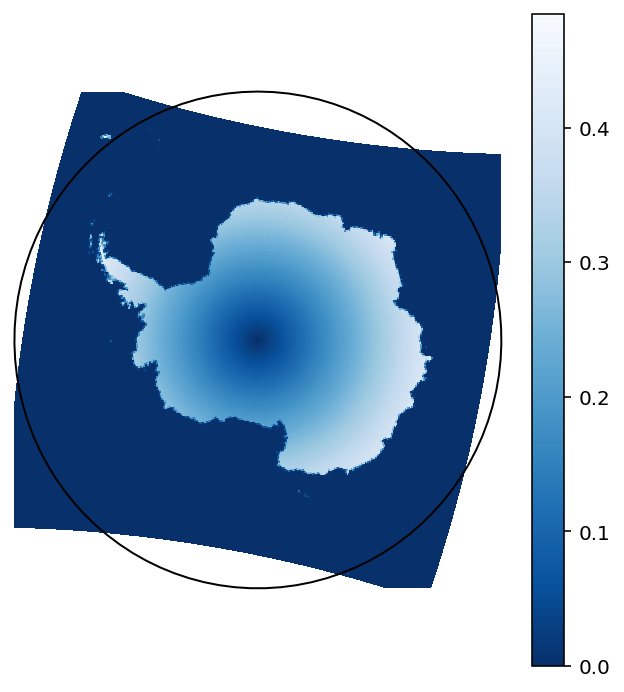

In [50]:
ax = plt.subplot(121,projection=crsx)
ax.set_extent(ext,crs=cartopy.crs.PlateCarree())
a = ax.pcolormesh(lon2d, lat2d, cos_lat_2d, transform=cartopy.crs.PlateCarree(), cmap='Blues_r')
ax.set_boundary(circle, transform=ax.transAxes)
plt.colorbar(a)

In [ ]:
    gmst = (
        (ds['tas'] * cos_lat_2d).sum(dim=['lat','lon']) /
        cos_lat_2d.sum(dim=['lat','lon'])
    )

In [51]:
from tqdm.autonotebook import tqdm 

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:1: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  """Entry point for launching an IPython kernel.


In [98]:
dl = dl.rename({'ncl1':'lon', 'ncl2': 'lat', 'ncl0':'time','ncl4':'lon', 'ncl5': 'lat', 'ncl3':'time'})

In [106]:
gmst = (dl.t2m_summer* cos_lat_2d).sum(dim=['lat','lon']) / cos_lat_2d.sum() 
gmst[gmst<100]=np.nan

In [107]:
dl

<xarray.Dataset>
Dimensions:     (lat: 262, lon: 240, ncl6: 240, ncl7: 262, ncl8: 240, ncl9: 262, time: 40)
Dimensions without coordinates: lat, lon, ncl6, ncl7, ncl8, ncl9, time
Data variables:
    t2m_summer  (time, lon, lat) float32 284.51562 284.4135 ... 279.53238
    t2m_winter  (time, lon, lat) float32 280.41394 280.33405 ... 276.8923
    masker      (ncl6, ncl7) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    height      (ncl8, ncl9) float64 -0.004977 -0.004977 ... -0.004977 -0.004977

(-22, -18)

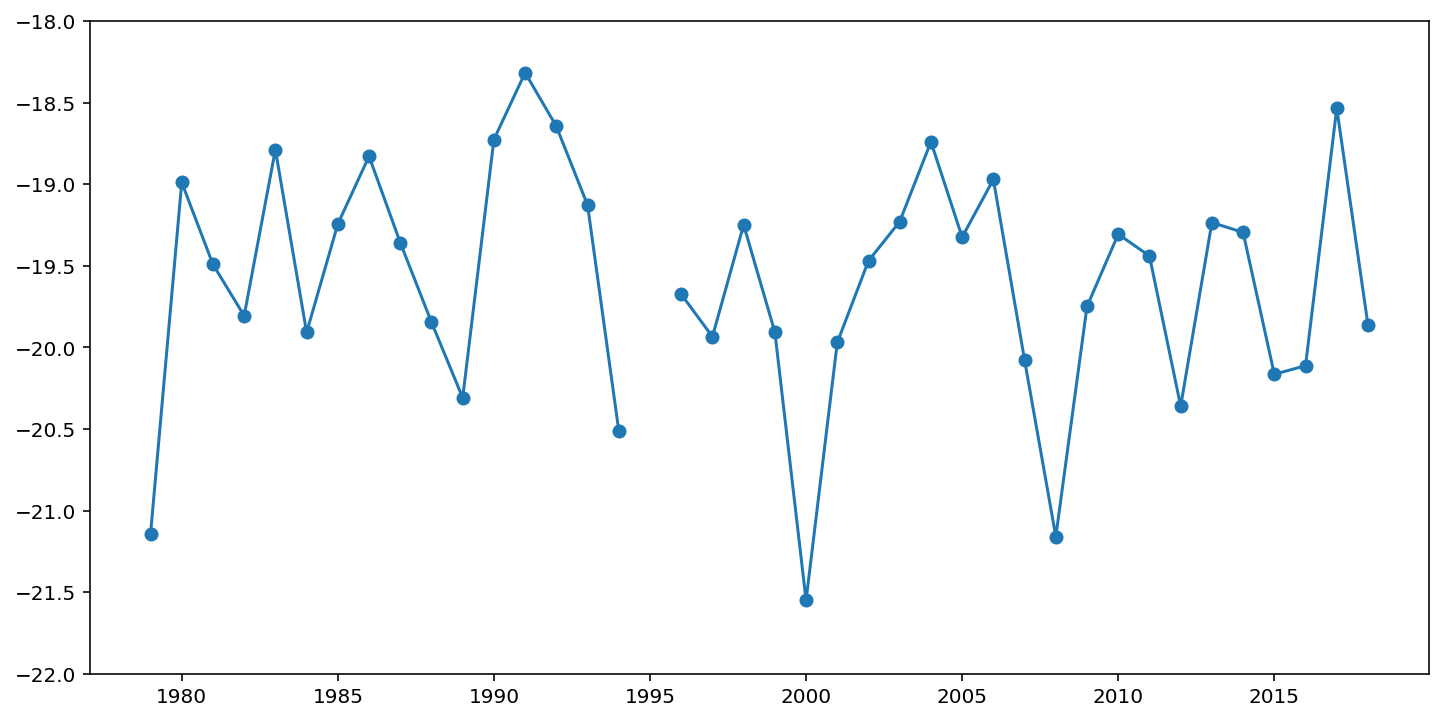

In [108]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(np.arange(1979,2019),gmst.values-273,marker='o')
ax.set_ylim(-22,-18)

In [109]:
gmst.mean()

<xarray.DataArray 't2m_summer' ()>
array(253.40179246)